In [80]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_models
import argparse
from PIL import Image
from train import COCOSegmentationDataset, SimultaneousTransform, center_crop_arr
from torchvision import transforms


In [81]:
# Setup PyTorch:
torch.manual_seed(42)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [82]:
# Load model:
latent_size = 256 // 8
model = DiT_models['DiT-S/8'](
    input_size=latent_size,
    num_classes=1
).to(device)


In [83]:
ckpt_path = "/home/jqi/Github/DiT/results/001-DiT-S-8/checkpoints/0070500.pt"
state_dict = find_model(ckpt_path)
model.load_state_dict(state_dict)
model.eval()  # important!
diffusion = create_diffusion('1000')
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(device)

In [307]:
transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])
dataset = COCOSegmentationDataset(root_dir='/home/jqi/Github/Data/Data/coco', split='train2017', transform=SimultaneousTransform(transform))
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


In [364]:
for i, (image, mask) in enumerate(loader):
    image = image.to(device)
    mask = mask.to(device)
    break

In [365]:
z = vae.encode(image).latent_dist.sample().mul_(0.18215)
z = torch.cat([z, z], 0)
y = torch.tensor([1], device=device)
y_null = torch.tensor([1] * 1, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=4.0)

In [366]:
samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
    )


100%|██████████| 1000/1000 [00:02<00:00, 450.33it/s]


In [367]:
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

In [368]:
save_image(samples, "sample.png", nrow=4, normalize=True, value_range=(-1, 1))

In [369]:
mask_vae = vae.encode(mask).latent_dist.sample().mul_(0.18215)
mask_vae = vae.decode(mask_vae / 0.18215).sample
mask_vae = mask_vae.squeeze(0)
mask_vae = mask_vae.detach().cpu().numpy()
mask_vae = mask_vae.transpose(1, 2, 0)
mask_vae = Image.fromarray((mask_vae * 255).astype('uint8'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


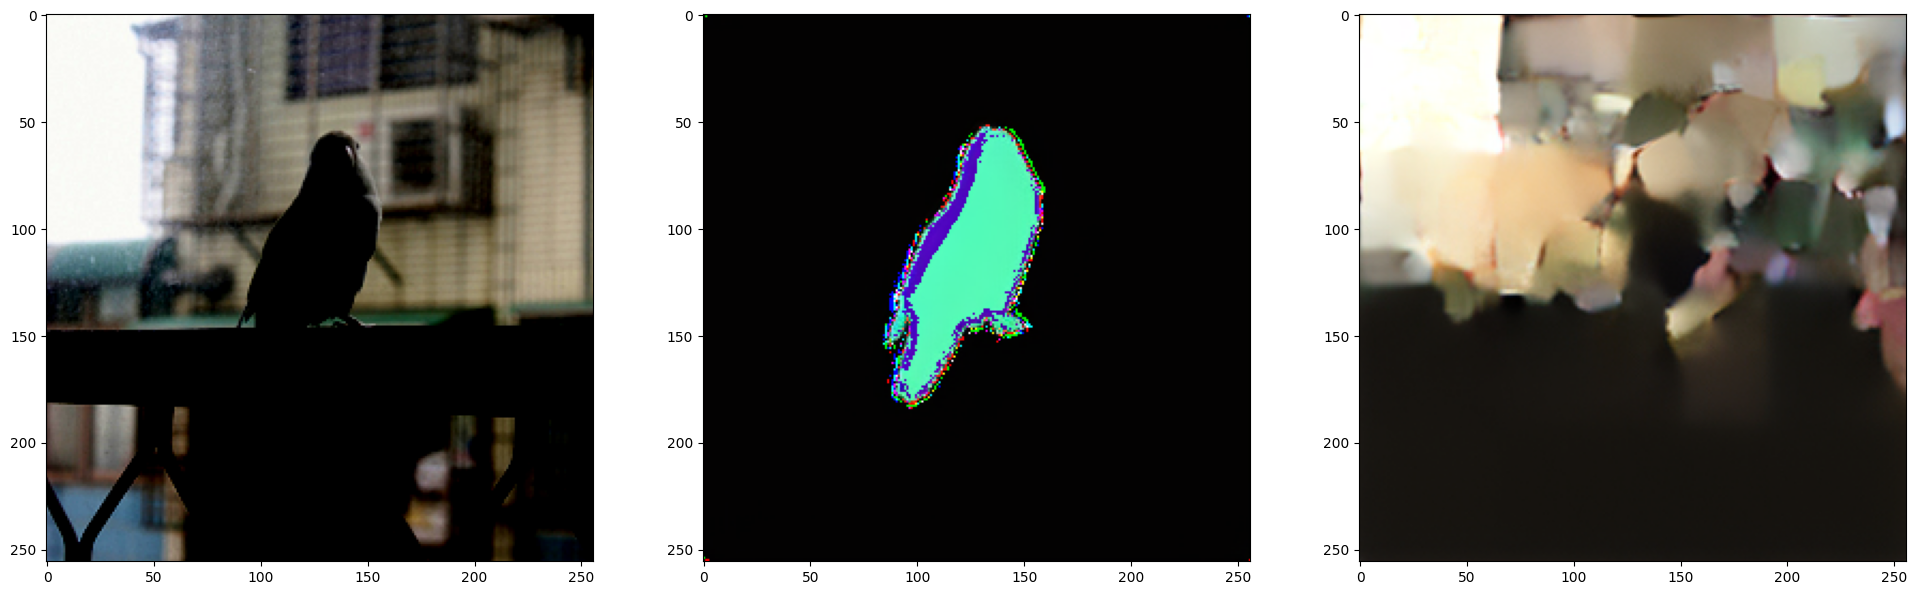

In [370]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 3, 2)
plt.imshow(mask_vae)
plt.subplot(1, 3, 3)
plt.imshow(Image.open("sample.png"))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


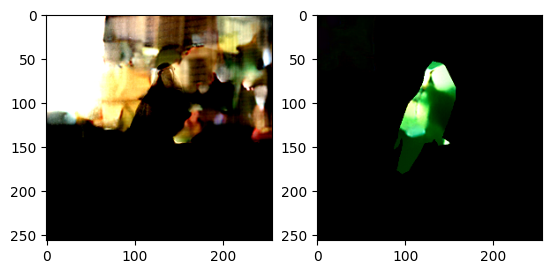

In [371]:
#simple overlap of the sample vs image and sample vs mask
import cv2
import numpy as np

overlaid = cv2.addWeighted(image[0].permute(1, 2, 0).cpu().numpy(), 1, samples[0].permute(1, 2, 0).cpu().numpy(), 1, 0)
overlaid_mask = cv2.addWeighted(mask[0].permute(1, 2, 0).cpu().numpy(), 1, samples[0].permute(1, 2, 0).cpu().numpy(), 1, 0)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(overlaid)
plt.subplot(1, 2, 2)
plt.imshow(overlaid_mask)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


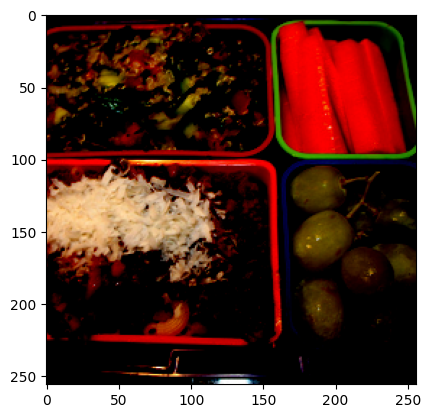

In [272]:
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
